### Experimento 1 — Línea base (k-search, pesos iguales)

Objetivo. Estimar la estructura natural de segmentación usando todas las variables con igual ponderación.
Preparación. Binarias en \{0,1\}; dens_int estandarizada (z-score). Imputaciones mínimas: medianas para dens_int; False para binarios faltantes (si existen).
Parrilla. k \in \{4,5,6,7,8,9,10,12\}; n_init=50; init="k-means++".
Selección. Máximo Silhouette con desempate por CH y tamaño mínimo de clúster ≥ 2%.

Resultado esperado para negocio. Perfiles a lo largo de un gradiente de adopción digital (uso, conexión, densidad de internet) que, al perfilar por edad/estrato/departamento, permitan identificar segmentos críticos y territorios con brechas.

### Experimento 2 — Ponderación por adopción (mayor peso a uso/conexión)

Objetivo. Forzar separación a lo largo del eje de adopción/uso para facilitar una lectura de “bajo/medio/alto” y su priorización.
Preparación. Multiplicar por un peso w>1 las columnas: Servicios_Telecomunicaciones_Si, conexion_hogar_si, free_uso_si, dens_int (p. ej., w=2). Estandarizar dens_int tras ponderación.
Parrilla. k \in \{4,5,6,7,8\}; n_init=50.
Selección. Igual criterio que en Exp. 1, añadiendo PS como criterio de interpretabilidad (preferir centroides binarios más “extremos” → descripciones más nítidas).

Resultado esperado para negocio. Clústers con rasgos muy claros (p. ej., “alta conexión/alto uso”, “baja conexión/bajo uso”), simplificando la explicación a actores no técnicos y la priorización de intervenciones.

### Experimento 3 — Estabilidad y coherencia territorial

Objetivo. Quedarse con una configuración robusta y con alineación territorial útil para focalización.
Preparación. Tomar la mejor configuración (k y pesos) de Exp. 1–2.
Protocolo. Ejecutar 30 corridas con seeds distintos y subsampling al 80% para medir ARI promedio. Calcular entropía normalizada de la distribución por Nombre Departamento en cada clúster; reportar también top-5 municipios por participación dentro de cada clúster.
Selección. Configuración con mayor ARI y menor entropía (coherencia territorial), sin deteriorar Silhouette frente a la alternativa competidora.

Resultado esperado para negocio. Clústers estables, con anclajes geográficos claros, que permitan asignar responsables y diseñar paquetes de intervención regionales.

* Silhouette (∈ [−1,1], mayor es mejor): cohesión vs separación (Euclídea).
* Calinski-Harabasz (CH) (≥0, mayor es mejor): varianza entre clústeres / intra.
* Davies-Bouldin (DB) (≥0, menor es mejor): promedio de “semejanzas” entre clústeres.
* Adjusted Rand Index (ARI) (∈ [−1,1], 0 ~ azar, 1 idéntico): estabilidad/consistencia de particiones.



In [2]:
# ============================================
# 0) Imports y utilidades
# ============================================
import os
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

# -------- Helpers de preparación --------
FEATURES = [
    "Servicios_Telecomunicaciones_No",
    "Servicios_Telecomunicaciones_Si",
    "Dispositivos_hogar_No",
    "conexion_hogar_si",
    "interrupciones_si",
    "frec_uso_si",
    "dens_int",
]

# Variables SOLO para perfilar (no entrenan el modelo)
SOCIO_GEO = [
    "EDAD", "ESTRATO", "NIVEL_PIRAMIDE",
    "MUNICIPIO_NOMBRE", "Nombre Departamento"
]

def load_data(path="../Data/data_procesada.csv"):
    df = pd.read_csv(path)
    # Asegurar columnas esperadas
    missing = [c for c in FEATURES if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en data_procesada: {missing}")

    # Coerción a numérico/bool
    for c in FEATURES:
        # Si es binario, mapear True/False/NaN a 1/0
        if c != "dens_int":
            df[c] = df[c].astype("float").astype("Int64")  # por si viene como 0/1/NaN
            df[c] = df[c].fillna(0).astype(int)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Imputación mínima para dens_int
    if df["dens_int"].isna().any():
        df["dens_int"] = df["dens_int"].fillna(df["dens_int"].median())

    return df

def apply_weights(X: pd.DataFrame, weights: dict | None):
    """Multiplica columnas por pesos; útil para el Experimento 2."""
    Xw = X.copy()
    if weights:
        for col, w in weights.items():
            if col in Xw.columns:
                Xw[col] = Xw[col].astype(float) * float(w)
    return Xw

def scale_numeric(X: pd.DataFrame, numeric_cols=("dens_int",)):
    Xs = X.copy()
    scaler = StandardScaler()
    Xs[list(numeric_cols)] = scaler.fit_transform(Xs[list(numeric_cols)])
    return Xs

# -------- Métricas y estabilidad --------
def compute_internal_metrics(X: np.ndarray, labels: np.ndarray) -> dict:
    # Silhouette requiere al menos 2 clústers y no todos los puntos iguales
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    ch  = calinski_harabasz_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    db  = davies_bouldin_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}

def profile_sharpness(centroids: pd.DataFrame, binary_cols: list[str]) -> float:
    """Promedio de distancia del centroide a 0.5 (cuanto mayor, más 'nítido')."""
    if not binary_cols:
        return np.nan
    diffs = []
    for col in binary_cols:
        if col in centroids.columns:
            diffs.append(np.abs(centroids[col] - 0.5))
    if not diffs:
        return np.nan
    return float(pd.concat(diffs, axis=1).mean().mean())

def cluster_size_ok(labels: np.ndarray, min_ratio=0.02) -> bool:
    n = len(labels)
    sizes = pd.Series(labels).value_counts(normalize=True)
    return (sizes >= min_ratio).all()

def stability_ari(X: np.ndarray, k: int, seeds: list[int], subsample=0.8) -> float:
    """Promedio de ARI entre múltiples corridas con submuestreo."""
    label_list = []
    rng = np.random.default_rng(42)
    n = X.shape[0]
    for seed in seeds:
        idx = rng.choice(n, size=int(n*subsample), replace=False)
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed)
        labels = kmeans.fit_predict(X[idx])
        # Volver a tamaño completo (asignación a vecinos más cercanos)
        # Para estabilidad comparamos solo intersecciones
        label_list.append((idx, labels))

    # Promedio de ARI en intersecciones
    if len(label_list) < 2:
        return np.nan
    aris = []
    for i in range(len(label_list)):
        for j in range(i+1, len(label_list)):
            idx_i, lab_i = label_list[i]
            idx_j, lab_j = label_list[j]
            common = np.intersect1d(idx_i, idx_j, assume_unique=False)
            if len(common) < 10:
                continue
            # Mapear a posiciones en cada subconjunto
            map_i = pd.Series(range(len(idx_i)), index=idx_i)
            map_j = pd.Series(range(len(idx_j)), index=idx_j)
            li = lab_i[map_i.loc[common].values]
            lj = lab_j[map_j.loc[common].values]
            aris.append(adjusted_rand_score(li, lj))
    return float(np.mean(aris)) if aris else np.nan

def geographic_entropy(df: pd.DataFrame, labels: np.ndarray, col_region="Nombre Departamento") -> float:
    """Entropía normalizada promedio de la distribución regional por clúster."""
    df_ = df[[col_region]].copy()
    df_["cluster"] = labels
    entropies = []
    for c, g in df_.groupby("cluster"):
        p = g[col_region].value_counts(normalize=True)
        H = -(p * np.log(p + 1e-12)).sum()
        H_max = np.log(len(p)) if len(p) > 1 else 1.0
        entropies.append(H / H_max)
    return float(np.mean(entropies)) if entropies else np.nan

def centroid_table(X: pd.DataFrame, labels: np.ndarray):
    """Promedio por clúster (binarios → tasas; dens_int → media)."""
    dfc = X.copy()
    dfc["cluster"] = labels
    cent = dfc.groupby("cluster").mean(numeric_only=True).sort_index()
    sizes = dfc["cluster"].value_counts().sort_index().to_frame(name="n")
    sizes["pct"] = sizes["n"] / len(X)
    return cent, sizes

# -------- Bucle de experimentos --------
def run_kmeans_grid(df: pd.DataFrame, k_values, weights=None, exp_name="exp"):
    # 1) Subconjunto de features
    X = df[FEATURES].copy()
    # 2) Pesos (opcional para Exp. 2)
    X = apply_weights(X, weights)
    # 3) Escalar dens_int
    X = scale_numeric(X, numeric_cols=("dens_int",))
    X_np = X.values

    results = []
    best = None

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=50, init="k-means++", random_state=123)
        labels = km.fit_predict(X_np)

        # Métricas internas
        m = compute_internal_metrics(X_np, labels)

        # Tamaño mínimo por clúster
        ok = cluster_size_ok(labels, min_ratio=0.02)

        # Centroides y nitidez de perfil
        cent, sizes = centroid_table(X, labels)
        ps = profile_sharpness(cent, [c for c in FEATURES if c != "dens_int"])

        # Estabilidad (rápida): seeds más pequeñas para la malla
        ari = stability_ari(X_np, k, seeds=[0,1,2,3,4], subsample=0.8)

        row = {
            "exp": exp_name, "k": k, "silhouette": m["silhouette"],
            "calinski_harabasz": m["calinski_harabasz"], "davies_bouldin": m["davies_bouldin"],
            "profile_sharpness": ps, "stability_ari": ari,
            "min_size_ok": ok, "sizes": sizes["pct"].round(3).to_dict()
        }
        results.append(row)

        # Actualizar mejor (por Silhouette, luego CH, luego PS y estabilidad)
        if ok:
            if best is None:
                best = (row, labels, cent, sizes)
            else:
                br = best[0]
                better = (
                    (row["silhouette"] > br["silhouette"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and row["calinski_harabasz"] > br["calinski_harabasz"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and np.isclose(row["calinski_harabasz"], br["calinski_harabasz"]) and row["profile_sharpness"] > br["profile_sharpness"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and np.isclose(row["calinski_harabasz"], br["calinski_harabasz"]) and np.isclose(row["profile_sharpness"], br["profile_sharpness"]) and row["stability_ari"] > br["stability_ari"] + 1e-6)
                )
                if better:
                    best = (row, labels, cent, sizes)

    results_df = pd.DataFrame(results).sort_values(["silhouette","calinski_harabasz"], ascending=[False, False])
    return results_df, best

def interpret_clusters(df: pd.DataFrame, labels: np.ndarray):
    """Perfiles con variables socio/geo (no utilizadas en el entrenamiento)."""
    out = {}

    # Anexar labels
    tmp = df.copy()
    tmp["cluster"] = labels

    # Resumen socio-demográfico
    socio_num = tmp.groupby("cluster")[["EDAD", "ESTRATO"]].agg(["mean","median","std","count"])
    # NIVEL_PIRAMIDE distribución
    piramide = (tmp
                .groupby(["cluster", "NIVEL_PIRAMIDE"])
                .size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).round(3))
                .unstack(fill_value=0))

    # Top departamentos y municipios por cluster
    depto = (tmp.groupby(["cluster","Nombre Departamento"]).size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(5))
                .to_frame("share"))
    mpio = (tmp.groupby(["cluster","MUNICIPIO_NOMBRE"]).size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(5))
                .to_frame("share"))

    out["socio_num"] = socio_num
    out["nivel_piramide"] = piramide
    out["top_departamentos"] = depto
    out["top_municipios"] = mpio
    return out

# ============================================
# 1) Cargar datos
# ============================================
df = load_data("../Data/data_procesada.csv")

# ============================================
# 2) Experimento 1 — Línea base
# ============================================
k_values_exp1 = [4,5,6,7,8,9,10,12]
res1, best1 = run_kmeans_grid(df, k_values_exp1, weights=None, exp_name="exp1")
print("Resumen EXP1 (top 10):")
print(res1.head(10))

# Interpretación del mejor de EXP1
row1, labels1, cent1, sizes1 = best1
geoH1 = geographic_entropy(df, labels1, col_region="Nombre Departamento")
print("\nMejor EXP1:", row1)
print("Entropía geográfica (promedio):", round(geoH1, 3))
print("\nCentroides EXP1:")
print(cent1.round(3))
print("\nTamaños EXP1:")
print(sizes1.assign(pct = (sizes1["pct"]*100).round(1)))

interp1 = interpret_clusters(df, labels1)
# Ejemplo de impresión breve:
print("\nTop departamentos EXP1:")
print(interp1["top_departamentos"].head(15))

# ============================================
# 3) Experimento 2 — Ponderación por adopción
# ============================================
weights_exp2 = {
    "Servicios_Telecomunicaciones_Si": 2.0,
    "conexion_hogar_si": 2.0,
    "free_uso_si": 2.0,
    "dens_int": 2.0
}
k_values_exp2 = [4,5,6,7,8]
res2, best2 = run_kmeans_grid(df, k_values_exp2, weights=weights_exp2, exp_name="exp2")
print("\nResumen EXP2 (top 10):")
print(res2.head(10))

row2, labels2, cent2, sizes2 = best2
geoH2 = geographic_entropy(df, labels2, col_region="Nombre Departamento")
print("\nMejor EXP2:", row2)
print("Entropía geográfica (promedio):", round(geoH2, 3))
print("\nCentroides EXP2:")
print(cent2.round(3))
print("\nTamaños EXP2:")
print(sizes2.assign(pct = (sizes2["pct"]*100).round(1)))

interp2 = interpret_clusters(df, labels2)
print("\nTop departamentos EXP2:")
print(interp2["top_departamentos"].head(15))

# ============================================
# 4) Experimento 3 — Estabilidad y coherencia
#     (usar la mejor configuración entre EXP1 y EXP2)
# ============================================
# Comparar el 'row1' vs 'row2' por Silhouette, y si empatan, por ARI y PS
def prefer(a, b):
    if a["silhouette"] > b["silhouette"] + 1e-6:
        return "A"
    if b["silhouette"] > a["silhouette"] + 1e-6:
        return "B"
    # desempates
    if a["stability_ari"] > b["stability_ari"] + 1e-6:
        return "A"
    if b["stability_ari"] > a["stability_ari"] + 1e-6:
        return "B"
    if a["profile_sharpness"] >= b["profile_sharpness"]:
        return "A"
    return "B"

choice = prefer(row1, row2)
if choice == "A":
    X_choice = scale_numeric(apply_weights(df[FEATURES], None), ("dens_int",))
    k_choice = row1["k"]
    labels_choice = labels1
    print("\n[EXP3] Partimos de la mejor de EXP1, k =", k_choice)
else:
    X_choice = scale_numeric(apply_weights(df[FEATURES], weights_exp2), ("dens_int",))
    k_choice = row2["k"]
    labels_choice = labels2
    print("\n[EXP3] Partimos de la mejor de EXP2, k =", k_choice)

# Estabilidad fina con 30 seeds
ari30 = stability_ari(X_choice.values, k_choice, seeds=list(range(30)), subsample=0.8)
geoH3 = geographic_entropy(df, labels_choice, col_region="Nombre Departamento")
print("ARI promedio (30 seeds):", round(ari30, 3))
print("Entropía geográfica (promedio):", round(geoH3, 3))

# Perfil final
centF, sizesF = centroid_table(scale_numeric(apply_weights(df[FEATURES], None), ("dens_int",)), labels_choice)
print("\nCentroides finales:")
print(centF.round(3))
print("\nTamaños finales:")
print(sizesF.assign(pct = (sizesF["pct"]*100).round(1)))

Resumen EXP1 (top 10):
    exp   k  silhouette  calinski_harabasz  davies_bouldin  profile_sharpness  \
7  exp1  12    0.581894        5735.242001        0.789126           0.468735   
6  exp1  10    0.552902        5379.713391        0.796562           0.458293   
5  exp1   9    0.527368        5221.567453        0.864359           0.446254   
4  exp1   8    0.505051        5115.507017        0.906332           0.450781   
3  exp1   7    0.489611        5012.203647        0.977816           0.438112   
2  exp1   6    0.464867        4833.685951        1.036473           0.423829   
1  exp1   5    0.438029        4939.333345        0.928904           0.424784   
0  exp1   4    0.381018        4792.824524        1.006874           0.392758   

   stability_ari  min_size_ok  \
7       0.971750         True   
6       0.819632         True   
5       0.804307         True   
4       0.872461         True   
3       0.893427         True   
2       0.919165         True   
1       0.958382

### Lectura por clústers (historias de segmento) — Mejor EXP1, k=12

A continuación, traducción de centroides a perfiles útiles para negocio. Entre paréntesis, el % del total:
* C6 (23.5%) — Conectados con interrupciones en zonas bajo promedio. Servicios sí (~0.99), conexión hogar sí (~0.99), interrupciones sí (1.0), dens_int −0.84. Lectura: grandes bolsas de usuarios conectados pero en territorios menos favorecidos a nivel de infraestructura; confiabilidad es el dolor principal (calidad de servicio).
* C0 (12.5%) — Conectados, sin interrupciones, en territorios bajo promedio. Conexión hogar 1.0, interrupciones 0.0, dens_int −0.85. Lectura: buen servicio a pesar del contexto; mantener y escalar buenas prácticas (operadores/planes).
* C2 (14.2%) y C1 (5.9%) — Conectados con interrupciones; contextos distintos. Conexión hogar ≈1.0, interrupciones 1.0; dens_int ≈0.07 (C2) y 1.01 (C1). Lectura: mismo dolor (interrupciones), contextos opuestos: C1 en zonas sobre promedio; C2 en zonas ~promedio. Top departamentos sugieren sesgos regionales (p. ej., C1 con Norte de Santander 33% y C2 con Atlántico 45%) → acciones regionales diferenciadas.
* C8 (4.0%) y C10 (2.5%) — Alta densidad territorial; trayectorias opuestas. C8: conexión hogar 1.0, interrupciones 0.32, dens_int 2.43 → adopción alta con retos de confiabilidad (priorizar continuidad). C10: servicios sí 0.86, conexión hogar 0.0, muchos sin dispositivos (0.57), dens_int 2.64 → viven en áreas muy favorecidas, pero el hogar sigue desconectado y sin equipos → brecha de acceso/dispositivos (subsidios, kits, alfabetización).
* C3 (5.5%) y C4 (7.5%) — Barrera de equipos/ hogar desconectado. C3: servicios sí 0.94, dispositivos_no 0.57, conexión 0.0, dens_int 1.21. C4: servicios sí 1.0, dispositivos_no 1.0, conexión 0.0, dens_int −0.39.Lectura: el cuello de botella son los equipos (y/o tipo de dispositivo: móvil vs PC) y la conexión fija en el hogar. C3 en territorios sobre promedio (alto potencial si se resuelve equipamiento). C4 en territorios bajo promedio (requerirá infraestructura + dispositivos).
* C9 (4.5%) — Doble brecha (servicios y dispositivos). Servicios_No 1.0, conexión hogar ~0.10, dispositivos_no 0.64, dens_int −0.15. Lectura: offline casi total; requiere paquetes integrales (cobertura, asequibilidad, dotación, formación).
* C5 (5.5%) y C7 (5.3%) — Casos mixtos. C5: conectados, sin interrupciones, dens_int 1.12 → maduro; mantener calidad. C7: servicios sí, sin conexión fija (0.0), pocas interrupciones, dens_int −0.40 → uso móvil‐centrico sin banda ancha fija (acciones de migración a fijo/Hogar).

### Comparativa EXP1 vs EXP2 (pesos a adopción)
* EXP2 (k=8) eleva profile_sharpness (0.70 vs 0.47) y mantiene buenas métricas internas, por lo que las descripciones se vuelven más nítidas (p. ej., grupos “alto/medio/bajo” en conexión/uso) y reduce el número de segmentos.
* **Trade-off**: EXP1 ofrece más granularidad (12 clústers) y ligeramente mejor Silhouette; EXP2 ofrece simpleza explicativa (8 clústers) y perfiles más marcados. La entropía territorial es similar (0.83–0.85).

### ¿Cómo responde esto a la pregunta de negocio?
* Identificación de poblaciones rezagadas:
    * Brecha de dispositivos/ hogar desconectado: C3, C4, C10, C9.
    * Calidad del servicio (interrupciones): C1, C2, C6, C8.
    * Uso móvil sin banda ancha fija: C7.
* Focalización territorial: usar la distribución por departamento/municipio de cada clúster (y la entropía) para escoger regiones piloto y asignar responsables.
* Diseño de intervención:
    * Dispositivos + asequibilidad + alfabetización (C3/C4/C10/C9).
    * Mejoras de continuidad/infraestructura (C1/C2/C6/C8).
    * Migración a fijo/planes hogar (C7).

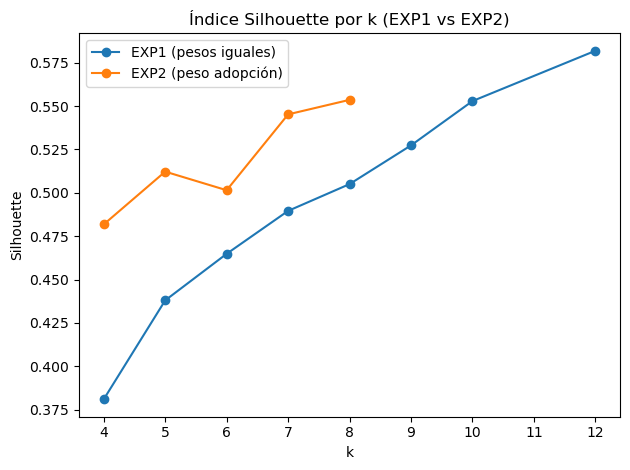

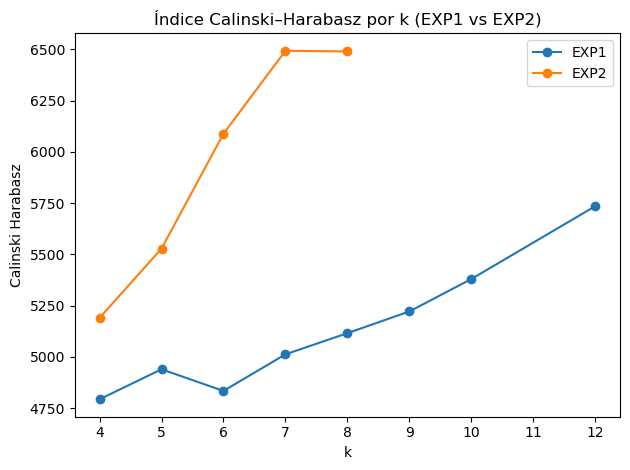

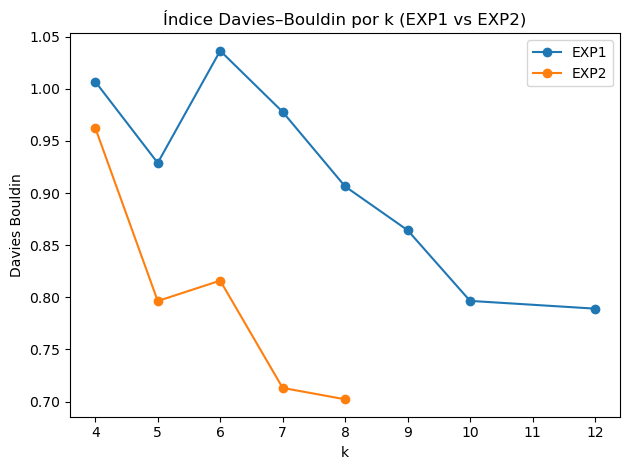

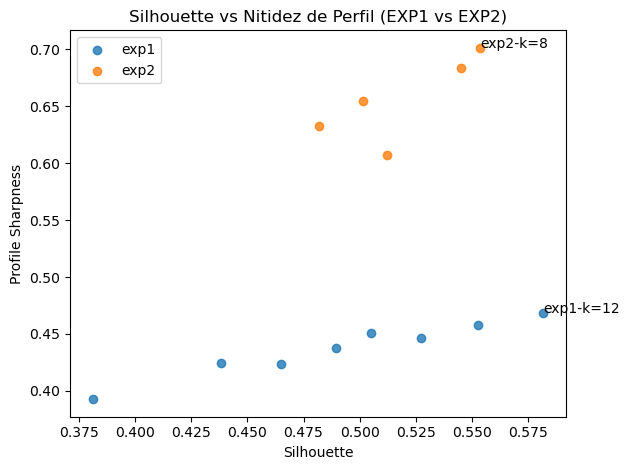

In [3]:
# ====== A) COMPARATIVAS DE CALIDAD ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric_by_k(res_df_list, metric="silhouette", title="Comparativa", label_map=None):
    plt.figure()
    for res_df in res_df_list:
        exp = res_df["exp"].iloc[0]
        label = label_map.get(exp, exp) if label_map else exp
        # Ordenar por k para trazado limpio
        d = res_df.sort_values("k")
        plt.plot(d["k"].values, d[metric].values, marker="o", label=label)
    plt.xlabel("k")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Silhouette
plot_metric_by_k([res1, res2], metric="silhouette",
                 title="Índice Silhouette por k (EXP1 vs EXP2)",
                 label_map={"exp1": "EXP1 (pesos iguales)", "exp2": "EXP2 (peso adopción)"})

# 2) Calinski-Harabasz
plot_metric_by_k([res1, res2], metric="calinski_harabasz",
                 title="Índice Calinski–Harabasz por k (EXP1 vs EXP2)",
                 label_map={"exp1": "EXP1", "exp2": "EXP2"})

# 3) Davies–Bouldin
plot_metric_by_k([res1, res2], metric="davies_bouldin",
                 title="Índice Davies–Bouldin por k (EXP1 vs EXP2)",
                 label_map={"exp1": "EXP1", "exp2": "EXP2"})

# 4) Trade-off Interpretabilidad vs Calidad
def plot_silhouette_vs_ps(res_df_list, title="Calidad vs. Interpretabilidad"):
    plt.figure()
    for res_df in res_df_list:
        exp = res_df["exp"].iloc[0]
        plt.scatter(res_df["silhouette"].values, res_df["profile_sharpness"].values, label=exp, alpha=0.8)
        # Anotar el mejor de cada experimento
        idx_best = res_df["silhouette"].idxmax()
        x = res_df.loc[idx_best, "silhouette"]
        y = res_df.loc[idx_best, "profile_sharpness"]
        k = res_df.loc[idx_best, "k"]
        plt.annotate(f"{exp}-k={k}", (x, y))
    plt.xlabel("Silhouette")
    plt.ylabel("Profile Sharpness")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_silhouette_vs_ps([res1, res2], title="Silhouette vs Nitidez de Perfil (EXP1 vs EXP2)")

### A) Visualización comparativa de calidad (selección de k y experimento)

Gráficos propuestos (1 por figura):
1. Silhouette vs k para EXP1 y EXP2 (líneas sobre el mismo eje).
2. Calinski–Harabasz vs k.
3. Davies–Bouldin vs k.
4. Trade-off Interpretabilidad vs Calidad: diagrama de dispersión Silhouette vs ProfileSharpness (cada punto es una configuración), para visualizar la tensión “separación” vs “nitidez de perfil”.

### Hallazgos
* Silhouette crece y alcanza su máximo en EXP1, k=12 (0.582) → separación alta; EXP2, k=8 logra perfiles más nítidos (ProfileSharpness 0.70) con leve sacrificio de Silhouette → opción simple de explicar.
* CH y DB respaldan la compacidad de ambos finalistas (EXP1-12 y EXP2-8).
* El scatter Silhouette–PS muestra claramente el trade-off entre granularidad (12 clústers) y simpleza explicativa (8 clústers).

Targets acceso/equipamiento: [3, 4, 7, 9, 10]
Targets confiabilidad/continuidad: [1, 2, 6]


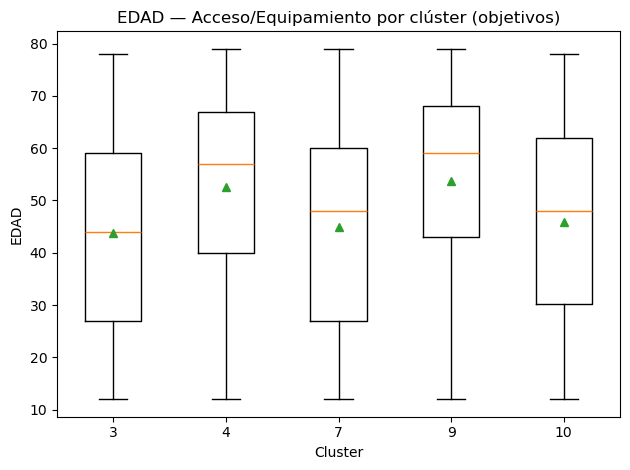

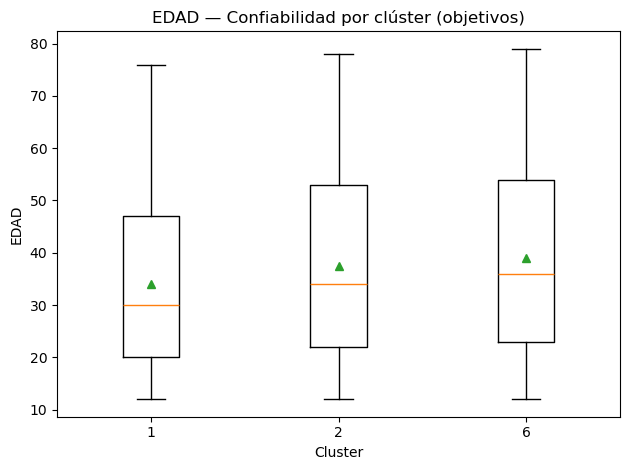

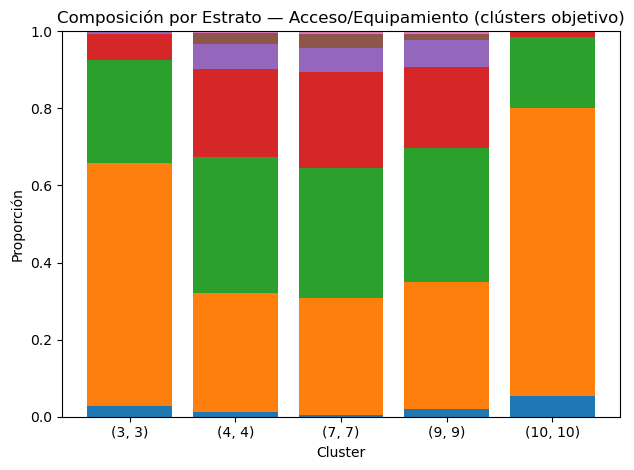

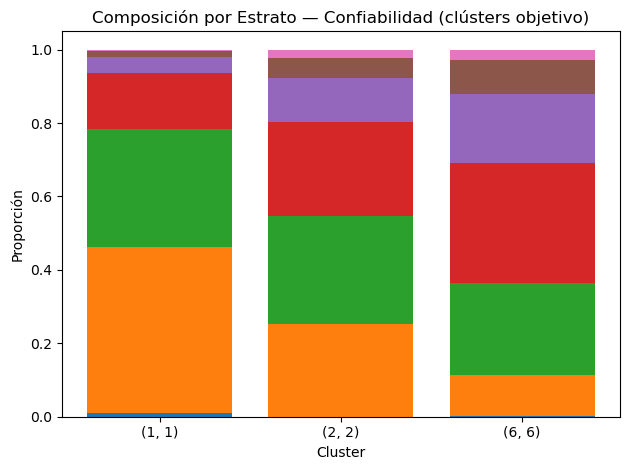

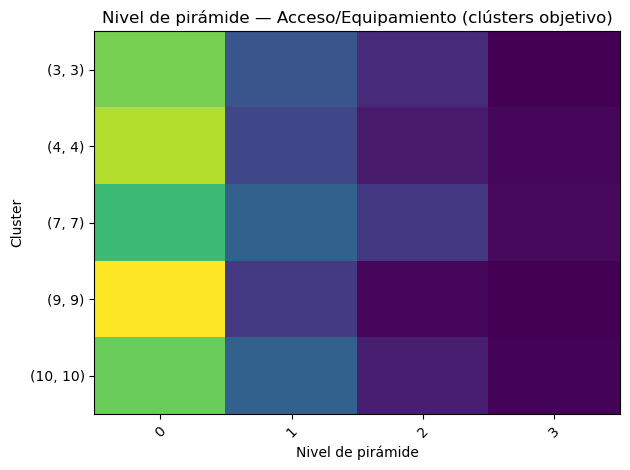

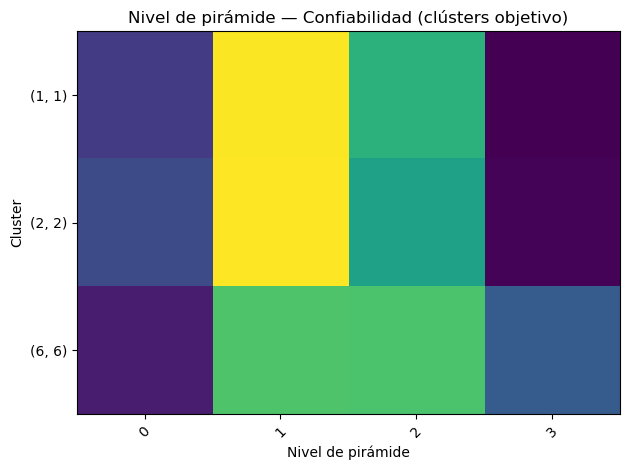

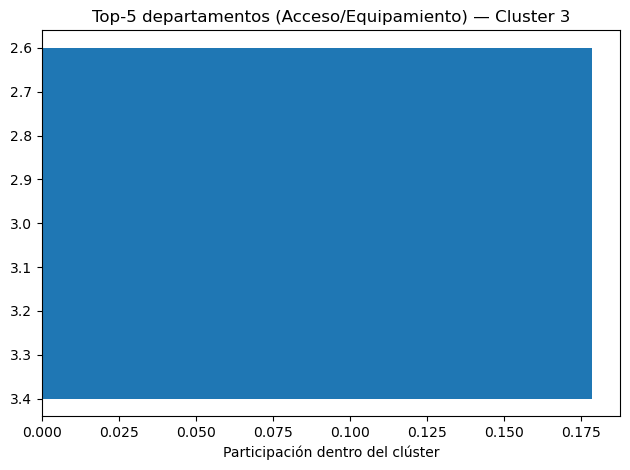

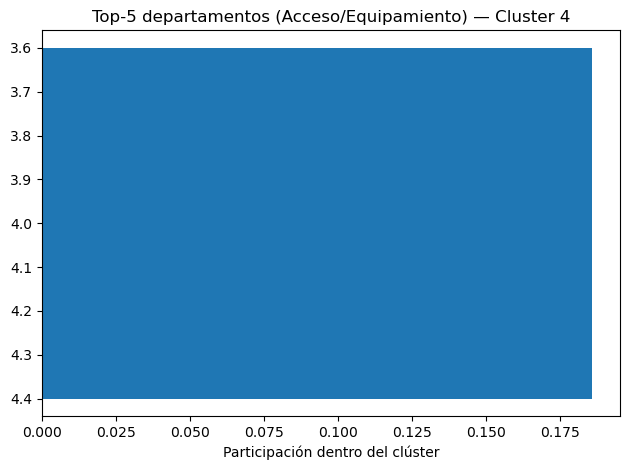

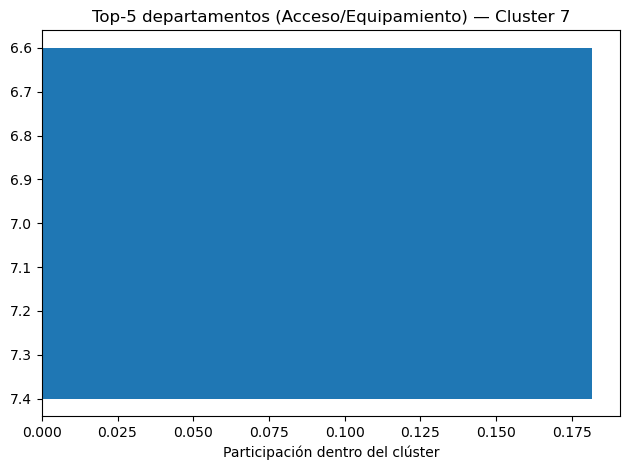

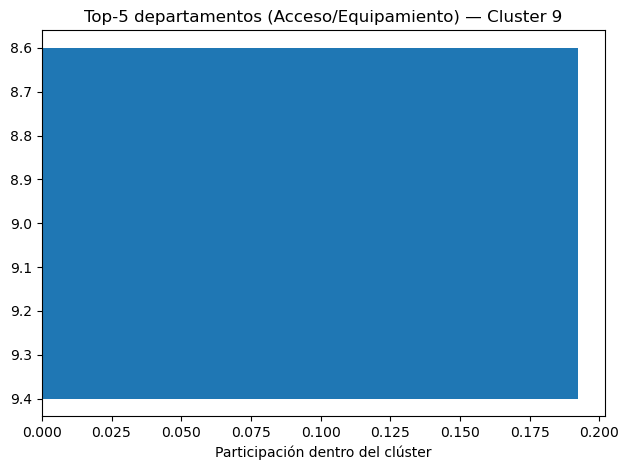

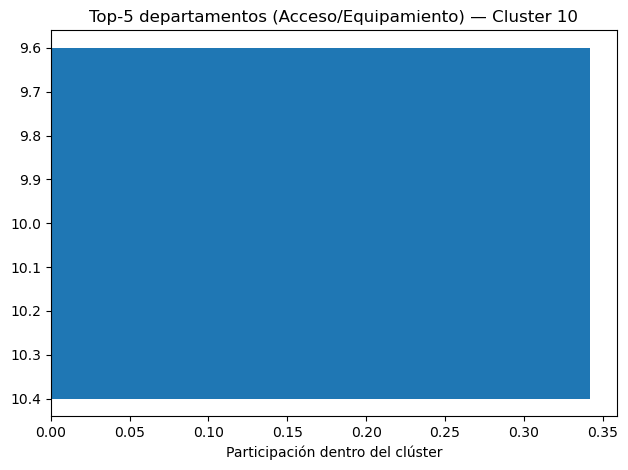

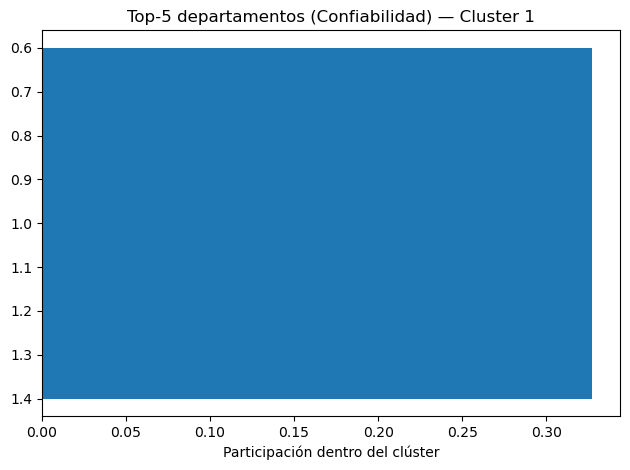

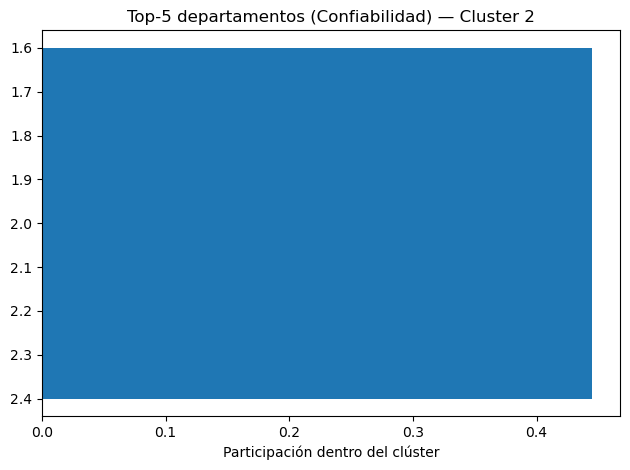

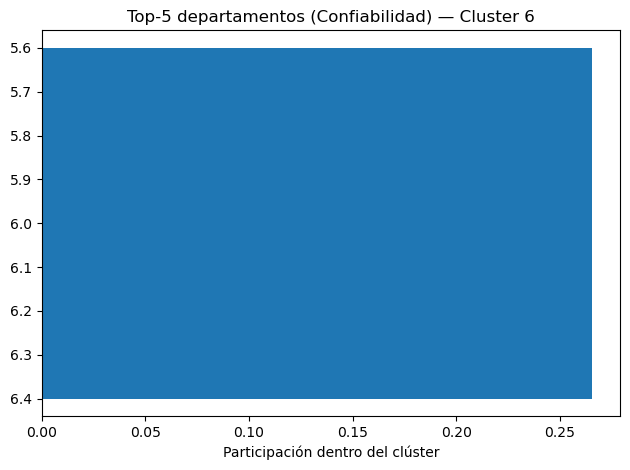

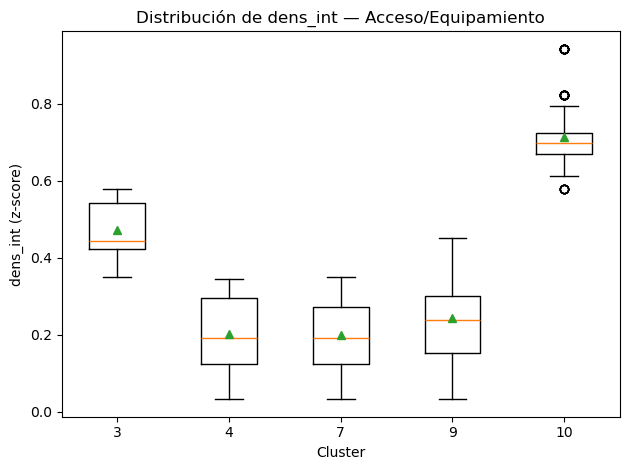

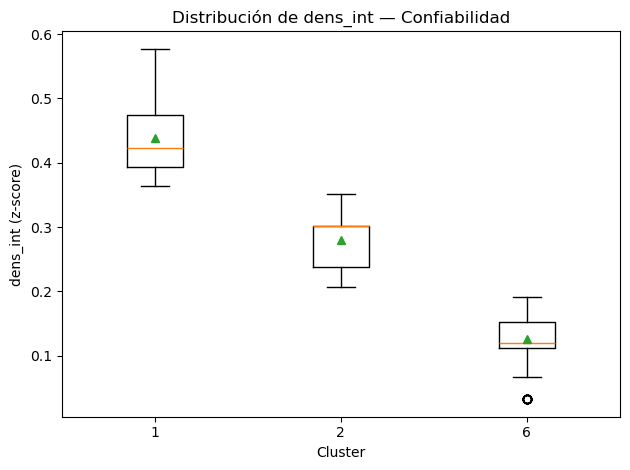

In [4]:
# ====== B) PERFILES SOCIODEMOGRÁFICOS Y TERRITORIALES ======
# Suponemos: df (datos originales con socio-demo y geo),
# labels1 (clusters EXP1), cent1 (centroides EXP1), interp1 (dict con tablas)

# 0) Selección de clústers objetivo a partir de centroides (EXP1)
def select_targets_from_centroids(centroids: pd.DataFrame):
    # Reglas simples (ajusta si deseas):
    acceso = centroids[
        (centroids["conexion_hogar_si"] <= 0.2) |
        (centroids["Dispositivos_hogar_No"] >= 0.5) |
        (centroids["Servicios_Telecomunicaciones_No"] >= 0.9)
    ].index.tolist()

    confiab = centroids[
        (centroids["conexion_hogar_si"] >= 0.9) &
        (centroids["interrupciones_si"] >= 0.9)
    ].index.tolist()

    return sorted(set(acceso)), sorted(set(confiab))

targets_acceso, targets_confiab = select_targets_from_centroids(cent1)
print("Targets acceso/equipamiento:", targets_acceso)
print("Targets confiabilidad/continuidad:", targets_confiab)

# 1) Boxplot de EDAD por clúster (solo clústers objetivo)
def plot_age_boxplot_by_clusters(df: pd.DataFrame, labels: np.ndarray, clusters: list, title_prefix="EDAD"):
    tmp = df[["EDAD"]].copy()
    tmp["cluster"] = labels
    data = [tmp.loc[tmp["cluster"]==c, "EDAD"].dropna().values for c in clusters]
    plt.figure()
    plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)
    plt.xlabel("Cluster")
    plt.ylabel("EDAD")
    plt.title(f"{title_prefix} por clúster (objetivos)")
    plt.tight_layout()
    plt.show()

plot_age_boxplot_by_clusters(df, labels1, targets_acceso, title_prefix="EDAD — Acceso/Equipamiento")
plot_age_boxplot_by_clusters(df, labels1, targets_confiab, title_prefix="EDAD — Confiabilidad")

# 2) Barras apiladas normalizadas de ESTRATO por clúster
def plot_stacked_bar_categorical(df: pd.DataFrame, labels: np.ndarray, clusters: list, cat_col="ESTRATO", title="Composición por Estrato"):
    tmp = df[[cat_col]].copy()
    tmp["cluster"] = labels
    # Tabla de proporciones: filas=cluster, columnas=categorías
    tab = (tmp[tmp["cluster"].isin(clusters)]
           .groupby(["cluster", cat_col]).size()
           .groupby(level=0).apply(lambda s: s / s.sum())
           .unstack(fill_value=0)
           .sort_index())

    plt.figure()
    bottom = np.zeros(tab.shape[0])
    x = np.arange(tab.shape[0])
    for cat in tab.columns:
        vals = tab[cat].values
        plt.bar(x, vals, bottom=bottom)
        bottom += vals
    plt.xticks(x, [str(c) for c in tab.index])
    plt.xlabel("Cluster")
    plt.ylabel("Proporción")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_stacked_bar_categorical(df, labels1, targets_acceso, cat_col="ESTRATO",
                             title="Composición por Estrato — Acceso/Equipamiento (clústers objetivo)")
plot_stacked_bar_categorical(df, labels1, targets_confiab, cat_col="ESTRATO",
                             title="Composición por Estrato — Confiabilidad (clústers objetivo)")

# 3) Heatmap de NIVEL_PIRAMIDE (usa tabla ya construida en interp1)
def plot_heatmap_piramide(pivot: pd.DataFrame, title="Nivel de Pirámide (proporciones)"):
    plt.figure()
    mat = pivot.values  # filas=cluster, columnas=nivel
    plt.imshow(mat, aspect="auto")
    plt.yticks(np.arange(pivot.shape[0]), [str(i) for i in pivot.index])
    plt.xticks(np.arange(pivot.shape[1]), [str(c) for c in pivot.columns], rotation=45)
    plt.xlabel("Nivel de pirámide")
    plt.ylabel("Cluster")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Filtrar a clústers objetivo
piv = interp1["nivel_piramide"].loc[targets_acceso]  # clústers de acceso
plot_heatmap_piramide(piv, title="Nivel de pirámide — Acceso/Equipamiento (clústers objetivo)")

piv2 = interp1["nivel_piramide"].loc[targets_confiab]  # clústers de confiabilidad
plot_heatmap_piramide(piv2, title="Nivel de pirámide — Confiabilidad (clústers objetivo)")

# 4) Top-5 departamentos por clúster (barras)
def plot_top_departments(interp_top_dept: pd.DataFrame, cluster_id: int, title_prefix="Top departamentos"):
    # interp_top_dept: índice jerárquico (cluster, depto), columna 'share'
    g = interp_top_dept.xs(cluster_id, level=0).sort_values("share", ascending=False).head(5)
    plt.figure()
    plt.barh(g.index.get_level_values(0), g["share"].values)
    plt.gca().invert_yaxis()
    plt.xlabel("Participación dentro del clúster")
    plt.title(f"{title_prefix} — Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()

for c in targets_acceso:
    plot_top_departments(interp1["top_departamentos"], c, title_prefix="Top-5 departamentos (Acceso/Equipamiento)")

for c in targets_confiab:
    plot_top_departments(interp1["top_departamentos"], c, title_prefix="Top-5 departamentos (Confiabilidad)")

# 5) Distribución de dens_int (boxplot por clúster objetivo)
def plot_dens_boxplot(df: pd.DataFrame, labels: np.ndarray, clusters: list, title="dens_int por clúster"):
    tmp = df[["dens_int"]].copy()
    tmp["cluster"] = labels
    data = [tmp.loc[tmp["cluster"]==c, "dens_int"].dropna().values for c in clusters]
    plt.figure()
    plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)
    plt.xlabel("Cluster")
    plt.ylabel("dens_int (z-score)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_dens_boxplot(df, labels1, targets_acceso, title="Distribución de dens_int — Acceso/Equipamiento")
plot_dens_boxplot(df, labels1, targets_confiab, title="Distribución de dens_int — Confiabilidad")

### 1. Distribución de Edad
* **Acceso/Equipamiento (clusters 3, 4, 7, 9, 10)**: Los boxplots muestran medianas de edad cercanas a los 50–60 años en los clústers 4, 9 y 10, mientras que los clústers 3 y 7 concentran medianas más bajas, en torno a 45 años. Esto indica que los hogares con limitaciones de conexión o falta de dispositivos tienden a estar asociados a poblaciones de mayor edad, especialmente en los clústers 4 y 9.
**Confiabilidad (clusters 1, 2, 6)**: Aquí las medianas están entre 30 y 40 años, con una distribución más homogénea. Esto sugiere que las dificultades de interrupciones del servicio afectan sobre todo a hogares con poblaciones más jóvenes, diferenciándose del perfil de acceso/equipamiento.

### 2. Composición por Estrato
* **Acceso/Equipamiento**: Se observa predominancia de estratos 1 y 2 en todos los clústers, en especial en el clúster 3 (mayoría absoluta en estrato 2) y en el clúster 10 (estratos 1–2 con más del 80%). El clúster 4 muestra mayor heterogeneidad, con participación importante de estrato 3. Esto confirma que la brecha de equipamiento y conexión está fuertemente concentrada en sectores socioeconómicos bajos.
* **Confiabilidad**: Aunque también dominan los estratos 1 y 2, se aprecia mayor presencia de estratos 3 y 4 en los clústers 2 y 6. Esto refuerza la lectura de que el problema de confiabilidad no es exclusivo de hogares vulnerables, sino que afecta también a sectores medios, donde la expectativa de calidad del servicio es más alta.

### 3. Nivel de Pirámide
* **Acceso/Equipamiento**: Los heatmaps muestran que los clústers 3, 4 y 10 concentran una alta proporción en los niveles bajos de la pirámide (nivel 0), mientras que el clúster 9 presenta la mayor concentración en nivel 0 pero con algo más de diversidad. Esto coincide con la evidencia de limitaciones en hogares de menor poder adquisitivo y baja capacidad de consumo digital.
* **Confiabilidad**: En los clústers 1 y 2 predomina el nivel 1, mientras que el clúster 6 tiene una mayor participación de los niveles 2 y 3. Esto indica que los problemas de interrupciones aparecen incluso en hogares con mayor capacidad de consumo, lo que sugiere que la brecha en este frente es más infraestructural que económica.

### 4. Distribución de dens_int
* **Acceso/Equipamiento**: Los boxplots muestran que la densidad relativa de internet (dens_int) es más baja en los clústers 4, 7 y 9, mientras que el clúster 10 presenta valores significativamente altos. Este contraste es interesante: el clúster 10 combina territorios de alta densidad digital con hogares que siguen desconectados o sin dispositivos, lo que apunta a un problema de adopción individual y acceso económico más que de infraestructura.
* **Confiabilidad**: El clúster 6 muestra la densidad más baja, mientras que los clústers 1 y 2 tienen densidades medias a altas. Esto sugiere que en territorios relativamente bien conectados, la población aún enfrenta problemas de continuidad en el servicio, lo que puede estar asociado a la calidad de la red local o al proveedor.

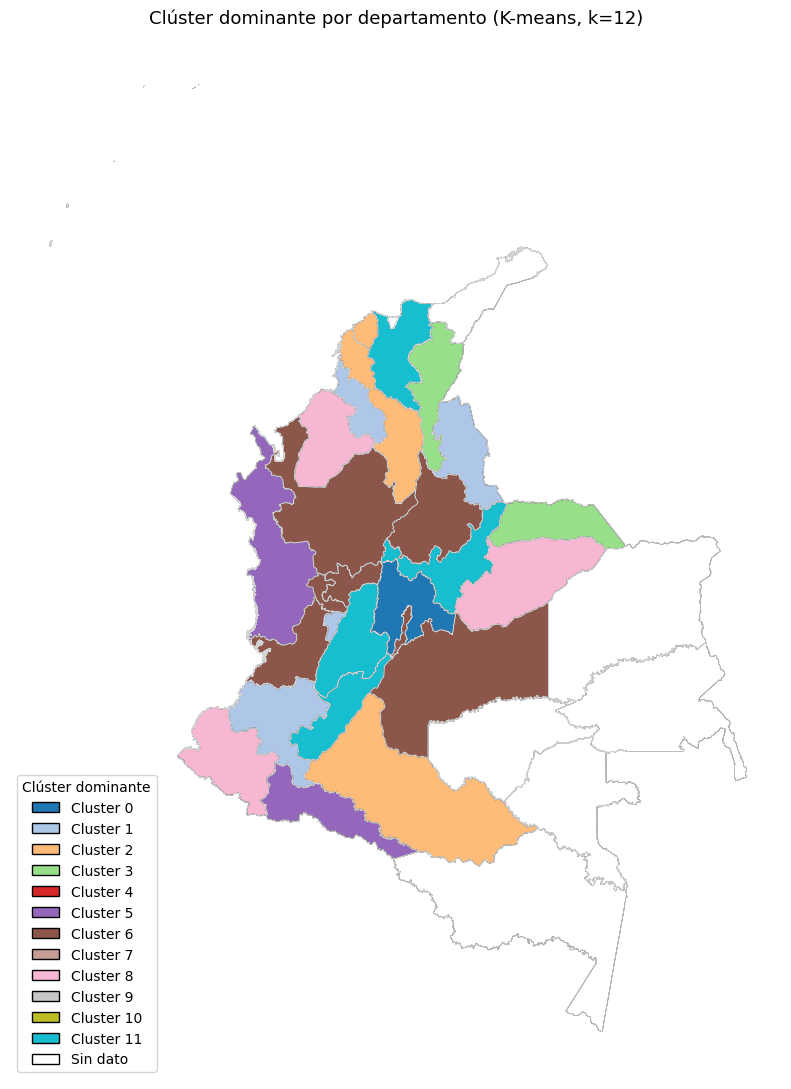

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1) Features para clustering (las que usaste en EXP1) ---
FEATURES = [
    "Servicios_Telecomunicaciones_No",
    "Servicios_Telecomunicaciones_Si",
    "Dispositivos_hogar_No",
    "conexion_hogar_si",
    "interrupciones_si",
    "frec_uso_si",
    "dens_int",
]

# --- 2) Preparar matriz de entrenamiento ---
X = df[FEATURES].copy()
scaler = StandardScaler()
X[["dens_int"]] = scaler.fit_transform(X[["dens_int"]])  # solo escalar dens_int

# --- 3) Entrenar K-means con k=12 (configuración seleccionada) ---
kmeans = KMeans(n_clusters=12, n_init=50, random_state=123)
labels = kmeans.fit_predict(X)

# Añadir columna de cluster al dataframe original
df_lab = df.copy()
df_lab["cluster"] = labels

# --- 4) Normalización para empatar con shapefile ---
def norm(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.upper()
             .str.normalize("NFKD").str.encode("ascii","ignore").str.decode("utf-8")
             .str.replace(r"[^A-Z0-9\s]", " ", regex=True)
             .str.replace(r"\s+", " ", regex=True)
             .str.strip())

df_lab["dep_norm"] = norm(df_lab["Nombre Departamento"])

# --- 5) Calcular clúster dominante por departamento ---
dom = (df_lab.groupby("dep_norm")["cluster"]
             .agg(lambda s: s.value_counts(normalize=True).idxmax())
             .rename("cluster_dom")
             .reset_index())

# --- 6) Cargar shapefile de departamentos ---
SHAPE_DPTOS = "../Geografia Colombia/gadm41_COL_shp/gadm41_COL_1.shp"
gdf_dpto = gpd.read_file(SHAPE_DPTOS)
gdf_dpto["dep_norm"] = norm(gdf_dpto["NAME_1"])

# --- 7) Merge shape + clusters ---
gdf_join = gdf_dpto.merge(dom, on="dep_norm", how="left")

# --- 8) Asignar colores a clústers ---
clusters_sorted = sorted(df_lab["cluster"].unique())
cmap = plt.get_cmap("tab20")
color_map = {c: cmap(i/len(clusters_sorted)) for i, c in enumerate(clusters_sorted)}
gdf_join["color"] = gdf_join["cluster_dom"].map(color_map).fillna("#FFFFFF")

# --- 9) Plot mapa ---
fig, ax = plt.subplots(figsize=(11, 11))
gdf_dpto.boundary.plot(ax=ax, color="lightgrey", linewidth=0.6)  # fondo contorno
gdf_join.plot(ax=ax, color=gdf_join["color"], edgecolor="black", linewidth=0.5)

# Leyenda
legend_patches = [Patch(facecolor=color_map[c], edgecolor="black", label=f"Cluster {c}")
                  for c in clusters_sorted]
legend_patches.append(Patch(facecolor="#FFFFFF", edgecolor="black", label="Sin dato"))
ax.legend(handles=legend_patches, title="Clúster dominante", loc="lower left", frameon=True)

ax.set_title("Clúster dominante por departamento (K-means, k=12)", fontsize=13, pad=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### 1. Concentración de clústers de acceso/equipamiento
* Clústeres 3, 4, 7, 9 y 10 (asociados a limitaciones de conexión o falta de dispositivos) se concentran principalmente en departamentos periféricos y de menor densidad digital.
    * En la Costa Caribe y Pacífica predominan clústers con déficit de acceso y equipamiento, reflejando barreras tanto económicas como de infraestructura.
    * En departamentos del sur y suroccidente, aparecen también clústers de acceso en territorios de baja densidad, lo que confirma la existencia de zonas aún desconectadas, incluso en áreas urbanas intermedias.

### 2. Concentración de clústers de confiabilidad
* Clústeres 1, 2 y 6 (problemas de interrupciones y calidad del servicio) aparecen en varios departamentos de la región andina y del oriente.
    * Esto indica que en zonas de alta densidad digital y cobertura aceptable, los usuarios aún enfrentan problemas de continuidad del servicio.
    * La concentración en departamentos con alta penetración de internet sugiere que la brecha no está en el acceso, sino en la robustez y confiabilidad de la red.

### 3. Departamentos con clústers de alto contraste
* Bogotá, Antioquia, Valle del Cauca y Santander: aparecen dominados por clústers donde la conexión y servicios existen, pero surgen problemas de calidad e interrupciones. Esto refleja la presión sobre la infraestructura en territorios de mayor demanda digital.
* Departamentos de la Orinoquía y Amazonía: presentan clústers de acceso/equipamiento, donde la baja densidad poblacional y las dificultades logísticas hacen más costosa la expansión de redes.
* Departamentos caribeños como Atlántico, Sucre o Bolívar: aparecen también en clústers con mezcla de acceso y confiabilidad, reflejando desigualdades al interior de las mismas regiones.

### 4. Implicaciones estratégicas
1. Acceso/equipamiento (Caribe, Pacífico, Amazonía y Orinoquía): la estrategia debe enfocarse en subsidios a dispositivos, programas de alfabetización digital y extensión de cobertura.
2. Confiabilidad (Andina, Bogotá, Antioquia, Valle): aquí la política debe centrarse en mejorar la calidad de la red, con énfasis en reducir interrupciones y aumentar la resiliencia de los proveedores.
3. Departamentos mixtos: requieren estrategias combinadas: por ejemplo, Atlántico y Bolívar necesitan tanto mejorar el acceso en zonas rurales como garantizar continuidad en áreas urbanas densas.